# Rice grain classification Neural Network

This notebook is a simple implementation of a neural network to classify rice grains. The dataset used is the [Rice (Cammeo and Osmancik)](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik) from UCI Machine Learning Repository. A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice. 

In [25]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Lambda

Now, we need to define 2 classes for our data in order to work with pytorch.

In [15]:
class RiceDataset(Dataset):
    def __init__(self, csv_file, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.data = pd.read_csv(csv_file)
        self.data = self.data.drop(0)
        self.data.fillna(0, inplace=True)
        self.data = self.data.dropna()
        self.data = self.data.reset_index(drop=True)

        # normalize each column
        for i in range(len(self.data.columns) - 1):
            self.data.iloc[:, i] = (self.data.iloc[:, i] - self.data.iloc[:, i].mean()) / self.data.iloc[:, i].std()


    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        data = self.data.iloc[idx, :-1].values.astype('float64')
        target = self.data.iloc[idx, -1]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            target = self.target_transform(target)
        return data, target

In [ ]:
train_dataset = RiceDataset('./data/rice_datasets/train.csv', 
                      transform=torch.from_numpy, 
                      target_transform=Lambda(lambda y: torch.tensor([1, 0]) if y == 'Cammeo' else torch.tensor([0, 1], dtype=torch.float64)))

test_dataset = RiceDataset('./data/rice_datasets/test.csv',
                        transform=torch.from_numpy, 
                        target_transform=Lambda(lambda y: torch.tensor([1, 0]) if y == 'Cammeo' else torch.tensor([0, 1], dtype=torch.float64)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Let's define the model class. 

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(7, 5, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(5, 2, dtype=torch.float64),
        )

    
    def forward(self, x):
        logits = self.relu_stack(x)
        return nn.functional.softmax(logits, dim=1)
    

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (relu_stack): Sequential(
    (0): Linear(in_features=7, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=2, bias=True)
  )
)


In [24]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

    return train_loss / size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

    return test_loss

We will use Adam optimizer and CrossEntropyLoss as the loss function.

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
loss_fn = nn.BCELoss()

Let's train the model and see the results.

In [20]:
epochs = 10
total_train_losses = []
total_test_losses = []

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train_loss = train(train_loader, model, loss_fn, optimizer)
    test_loss = test(test_loader, model, loss_fn)
    total_train_losses.append(train_loss)
    total_test_losses.append(test_loss)

print('Done!')

Epoch 1
-------------------------------
loss: 0.666673  [    0/ 3047]
loss: 0.219773  [  640/ 3047]
loss: 0.204868  [ 1280/ 3047]
loss: 0.124417  [ 1920/ 3047]
loss: 0.146407  [ 2560/ 3047]
Test Error: 
 Accuracy: 92.1%, Avg loss: 0.003250 

Epoch 2
-------------------------------
loss: 0.181541  [    0/ 3047]
loss: 0.254110  [  640/ 3047]
loss: 0.262467  [ 1280/ 3047]
loss: 0.257686  [ 1920/ 3047]
loss: 0.153816  [ 2560/ 3047]
Test Error: 
 Accuracy: 92.5%, Avg loss: 0.003481 

Epoch 3
-------------------------------
loss: 0.215540  [    0/ 3047]
loss: 0.191004  [  640/ 3047]
loss: 0.113356  [ 1280/ 3047]
loss: 0.190378  [ 1920/ 3047]
loss: 0.265382  [ 2560/ 3047]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.003176 

Epoch 4
-------------------------------
loss: 0.130220  [    0/ 3047]
loss: 0.216968  [  640/ 3047]
loss: 0.324268  [ 1280/ 3047]
loss: 0.289880  [ 1920/ 3047]
loss: 0.164207  [ 2560/ 3047]
Test Error: 
 Accuracy: 92.1%, Avg loss: 0.003072 

Epoch 5
------------------------

Plot of the accuracy and loss graphs.

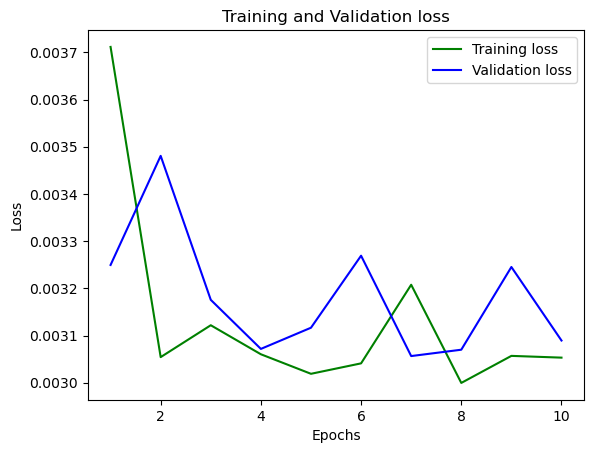

In [21]:
epochs = range(1, epochs + 1)

plt.plot(epochs, total_train_losses, 'g', label='Training loss')
plt.plot(epochs, total_test_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()